In [61]:
import pandas as pd
import os 
import numpy as np  
import librosa 
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torch  
import torch.nn as nn   
from typing import List
import pytorch_lightning as pl  
import torch.nn.functional as F 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [62]:
audio_dataframe = pd.read_csv('label_dataframe.csv')    

In [63]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir):
        self.dataframe = dataframe['file_name']
        self.root_dir = root_dir
        self.root_note = dataframe['root_note']
        self.chord_type = dataframe['chord_type']

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Ensure correct indexing
        file_name = self.dataframe.iloc[idx]
        root_note = self.root_note.iloc[idx]
        chord_type = self.chord_type.iloc[idx]
        # Construct the file path correctly
        chromagram_path = os.path.join(self.root_dir, file_name.split('.wav')[0] + '_chromagram.npy')
        
        try:
            data = torch.Tensor(np.load(chromagram_path))
        except FileNotFoundError as e:
            print(f"Error: File not found: {chromagram_path}")
            raise e
        except Exception as e:
            print(f"An error occurred while loading the file: {chromagram_path}")
            raise e
        
        return data, file_name, root_note, chord_type

In [64]:
columns_to_drop = ['label', 'instrument', 'type_of_sound']

X = audio_dataframe.drop(columns=columns_to_drop, axis=1)
y = audio_dataframe['root_note']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

for index, row in X_train.iterrows(): 
    try:
        chroma_oath = os.path.join('IDMT-SMT-CHORDS/chromagrams', row[0].split('.wav')[0] + '_chromagram.npy')
        #print(chroma_oath)
    except:
        print('gasdf') 


train_dataloader = CustomDataset(dataframe=X_train, root_dir='IDMT-SMT-CHORDS/chromagrams')
test_dataloader = CustomDataset(dataframe=X_test, root_dir='IDMT-SMT-CHORDS/chromagrams')
val_dataloader = CustomDataset(dataframe=X_val, root_dir='IDMT-SMT-CHORDS/chromagrams')

/var/folders/v9/jdh_sf0s6059j5bw53rnglhr0000gn/T/ipykernel_41975/2936010560.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chroma_oath = os.path.join('IDMT-SMT-CHORDS/chromagrams', row[0].split('.wav')[0] + '_chromagram.npy')


In [72]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, encoded_dim):
        super(Encoder, self).__init__()
        layers = []
        for h_dim in hidden_dims:
            layers.append(nn.Sequential(
                nn.Linear(input_dim, h_dim),
                nn.ReLU(),
                nn.BatchNorm1d(h_dim)
            ))
            input_dim = h_dim
        layers.append(nn.Linear(input_dim, encoded_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class Decoder(nn.Module):
    def __init__(self, encoded_dim, hidden_dims, output_dim):
        super(Decoder, self).__init__()
        layers = []
        hidden_dims.reverse()
        for h_dim in hidden_dims:
            layers.append(nn.Sequential(
                nn.Linear(encoded_dim, h_dim),
                nn.ReLU(),
                nn.BatchNorm1d(h_dim)
            ))
            encoded_dim = h_dim
        layers.append(nn.Linear(encoded_dim, output_dim))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)


class Autoencoder(pl.LightningModule):
    def __init__(self, input_dim=12, hidden_dims=None, encoded_dim=12, learning_rate=1e-4):
        super(Autoencoder, self).__init__()
        if hidden_dims is None:
            hidden_dims = [128, 64, 32]
        self.encoder = Encoder(input_dim, hidden_dims, encoded_dim)
        self.decoder = Decoder(encoded_dim, hidden_dims, input_dim)
        self.learning_rate = learning_rate
        self.train_losses = []
        self.val_losses = []
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def training_step(self, batch, batch_idx):
        inputs, _, _ , _= batch
        inputs = inputs.view(inputs.size(0), -1)
        outputs = self.forward(inputs)
        loss = nn.MSELoss()(outputs, inputs)
        self.log('train_loss', loss, prog_bar=True)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, _, _, _ = batch
        inputs = inputs.view(inputs.size(0), -1)
        outputs = self.forward(inputs)
        loss = nn.MSELoss()(outputs, inputs)
        self.log('val_loss', loss, prog_bar=True)
        self.val_losses.append(loss.item())
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def encode(self, x): 
        return self.encoder(x)

In [74]:
# Hyperparameters
input_dim = 12  # For MNIST dataset
hidden_dims = [128, 64, 32]
encoded_dim = 12
learning_rate = 1e-4
batch_size = 64
num_epochs = 100

columns_to_drop = ['label', 'instrument', 'type_of_sound']

X = audio_dataframe.drop(columns=columns_to_drop, axis=1)
y = audio_dataframe['root_note']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

train_dataset = CustomDataset(dataframe=X_train, root_dir='IDMT-SMT-CHORDS/chromagrams')
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = CustomDataset(dataframe=X_test, root_dir='IDMT-SMT-CHORDS/chromagrams')
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = CustomDataset(dataframe=X_val, root_dir='IDMT-SMT-CHORDS/chromagrams')
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

full_dataset= CustomDataset(dataframe=X, root_dir='IDMT-SMT-CHORDS/chromagrams')
full_dataloader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)


Training step

In [75]:

autoencoder = Autoencoder(input_dim, hidden_dims, encoded_dim, learning_rate)

# Training
trainer = pl.Trainer(max_epochs=num_epochs)
trainer.fit(autoencoder, train_dataloader, val_dataloader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 12.8 K
1 | decoder | Decoder | 12.8 K
------------------------------------
25.7 K    Trainable params
0         Non-trainable params
25.7 K    Total params
0.103     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


PLOTING THE TRAINING AND VALIDATION LOSS

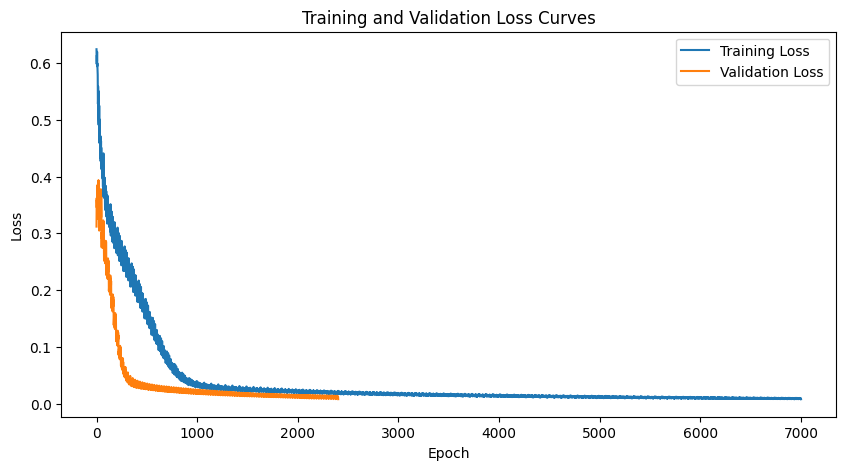

In [76]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(autoencoder.train_losses, label='Training Loss')
plt.plot(autoencoder.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

In [43]:
# Inference to get encoded data
autoencoder.eval()  # Set model to evaluation mode

encoded_data_list = []
file_names_list = []
root_note_list = []
chord_type_list = []
# Iterate over DataLoader
for batch in full_dataloader:
    batch_data, file_names, root_notes, chord_type = batch
    batch_data = batch_data.view(batch_data.size(0), -1).float()
    with torch.no_grad():
        encoded_batch = autoencoder.encode(batch_data)
    encoded_data_list.append(encoded_batch.cpu().numpy())
    file_names_list.extend(file_names)
    root_note_list.extend(root_notes)
    chord_type_list.extend(chord_type)
# Concatenate all encoded data
encoded_data = np.concatenate(encoded_data_list, axis=0)

# Save to DataFrame with filenames
encoded_df = pd.DataFrame(encoded_data, columns=[f'encoded_{i}' for i in range(encoded_dim)])
encoded_df.insert(0, 'file_name', file_names_list)
encoded_df.insert(1, 'root_note', root_note_list)
encoded_df.insert(2, 'chord_type', chord_type_list)
print(encoded_df.head())  # Display the first few rows of the DataFrame

# Save the DataFrame to a CSV file
encoded_df.to_csv('encoded_data.csv', index=False)

  file_name root_note chord_type  encoded_0  encoded_1  encoded_2  encoded_3  \
0  0000.wav         C        maj   0.129152   1.273247   1.097751  -0.734784   
1  0001.wav         C      maj/3  -0.182703   0.842220   1.395602  -0.417836   
2  0002.wav         C      maj/5   0.314797   0.200055   0.974930  -1.322679   
3  0003.wav        C#        maj   1.646713  -0.900243  -0.739083  -0.241195   
4  0004.wav        C#      maj/3   1.265869  -1.524436  -0.251477   0.584882   

   encoded_4  encoded_5  encoded_6  encoded_7  encoded_8  encoded_9  \
0  -0.046090   0.829727   0.691609  -0.672840  -0.176481  -0.258161   
1  -0.759786   0.435047   0.769463  -1.090914  -0.445101   0.425359   
2   0.937493   1.102850   1.425577  -1.165002   1.566589  -0.385265   
3   1.372749   0.535592   0.750240   1.277296   1.448275  -0.557173   
4   0.366822   1.072888   0.459393   0.203338   0.123134   0.660635   

   encoded_10  encoded_11  
0   -0.337874   -1.387573  
1   -0.293214   -1.160000  
2   -0.6

Saving the weights of the autoencoder

In [44]:
torch.save(autoencoder.state_dict(), 'autoencoder.pth')

In [45]:
audio_dataframe = pd.read_csv('encoded_data.csv') 
audio_dataframe.head()

,file_name,root_note,chord_type,encoded_0,encoded_1,encoded_2,encoded_3,encoded_4,encoded_5,encoded_6,encoded_7,encoded_8,encoded_9,encoded_10,encoded_11
0,0000.wav,C,maj,0.129152,1.273247,1.097751,-0.734784,-0.046090,0.829727,0.691609,-0.672840,-0.176481,-0.258161,-0.337874,-1.387573
1,0001.wav,C,maj/3,-0.182703,0.842220,1.395602,-0.417836,-0.759786,0.435047,0.769463,-1.090914,-0.445101,0.425359,-0.293214,-1.160000
2,0002.wav,C,maj/5,0.314797,0.200055,0.974930,-1.322679,0.937493,1.102850,1.425577,-1.165002,1.566588,-0.385265,-0.697246,-1.335541
3,0003.wav,C#,maj,1.646713,-0.900243,-0.739083,-0.241195,1.372749,0.535592,0.750240,1.277296,1.448275,-0.557173,-0.289716,-0.114156
4,0004.wav,C#,maj/3,1.265869,-1.524436,-0.251477,0.584882,0.366822,1.072888,0.459393,0.203338,0.123134,0.660635,-0.148685,0.544350


In [46]:
autoencoder_approach_dataframe = pd.DataFrame(columns = ['file_name','root_note', 'chord_type', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
for index, row in audio_dataframe.iterrows(): 
    file_name = row['file_name']
    root_note = row['root_note']
    chord_type = row['chord_type']
    id = os.path.split(file_name)[-1].split('.')[0] 
    filename_chromagram = id + '_chromagram.npy'
    chromagram = np.load(os.path.join('IDMT-SMT-CHORDS/chromagrams', filename_chromagram))
    data_list = [file_name, root_note, chord_type]
    for i in range(12):
        data_list.append(np.sum(chromagram[i]))

    autoencoder_approach_dataframe.loc[index] = data_list
autoencoder_approach_dataframe.to_csv('autoencoder_approach_dataframe.csv', index=False)

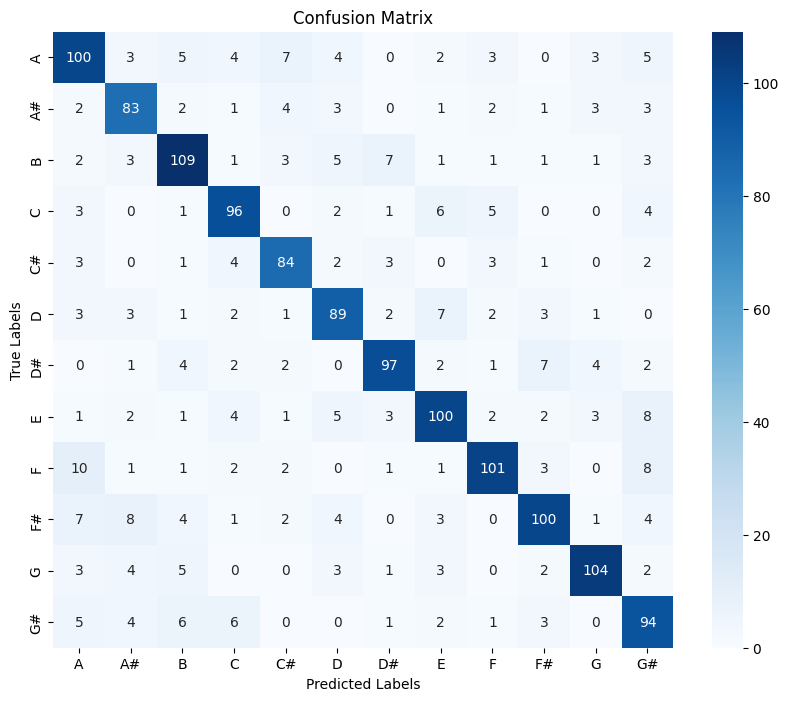

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       136
           1       0.74      0.79      0.76       105
           2       0.78      0.80      0.79       137
           3       0.78      0.81      0.80       118
           4       0.79      0.82      0.80       103
           5       0.76      0.78      0.77       114
           6       0.84      0.80      0.82       122
           7       0.78      0.76      0.77       132
           8       0.83      0.78      0.80       130
           9       0.81      0.75      0.78       134
          10       0.87      0.82      0.84       127
          11       0.70      0.77      0.73       122

    accuracy                           0.78      1480
   macro avg       0.78      0.78      0.78      1480
weighted avg       0.78      0.78      0.78      1480



In [47]:
label_encoder = LabelEncoder()
autoencoder_approach_dataframe['root_note'] = label_encoder.fit_transform(autoencoder_approach_dataframe['root_note'])
# Splitting data into train and test sets
autoencoder_approach_dataframe.to_csv('label_autoencoder_approach_df.csv', index=False)
X_full_train, X_full_test, y_train, y_test = train_test_split(autoencoder_approach_dataframe.drop(columns='root_note'), autoencoder_approach_dataframe['root_note'], test_size=0.2, random_state=42)
X_train = X_full_train.drop(columns=['file_name', 'chord_type'])
X_test = X_full_test.drop(columns=['file_name', 'chord_type'])

# Fitting a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Running inference on test set
y_pred = rf_classifier.predict(X_test)
# Computing classification metrics
classification_metrics = classification_report(y_test, y_pred)
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print(classification_metrics)

In [48]:
def filter_chords(X, y_test, column_name='chord_type'):
    """Filter the dataframe into normal chords and inversions based on the chord type column.

    Args:
        df (pd.DataFrame): The dataframe to filter.
        column_name (str): The name of the column to check for inversions (default 'chord_type').

    Returns:
        tuple: Two dataframes, the first with normal chords, the second with inversions.
    """
    df = pd.concat([X, y_test], axis=1) 
    normal_chords = df[~df[column_name].str.contains('/')]
    inversions = df[df[column_name].str.contains('/')]
    # get the indexes of the dataframe that contains normal chords  
    X_normal = normal_chords.drop(columns='root_note')
    y_normal = normal_chords['root_note']   

    X_inversions = inversions.drop(columns='root_note')
    y_inversions = inversions['root_note']
    

    X_normal = X_normal.drop(columns=['file_name', 'chord_type']) 
    X_inversions = X_inversions.drop(columns=['file_name', 'chord_type'])
    return X_normal, y_normal, X_inversions, y_inversions   


In [49]:
X_normal, y_normal, X_inversions, y_inversions = filter_chords(X_full_test, y_test)     

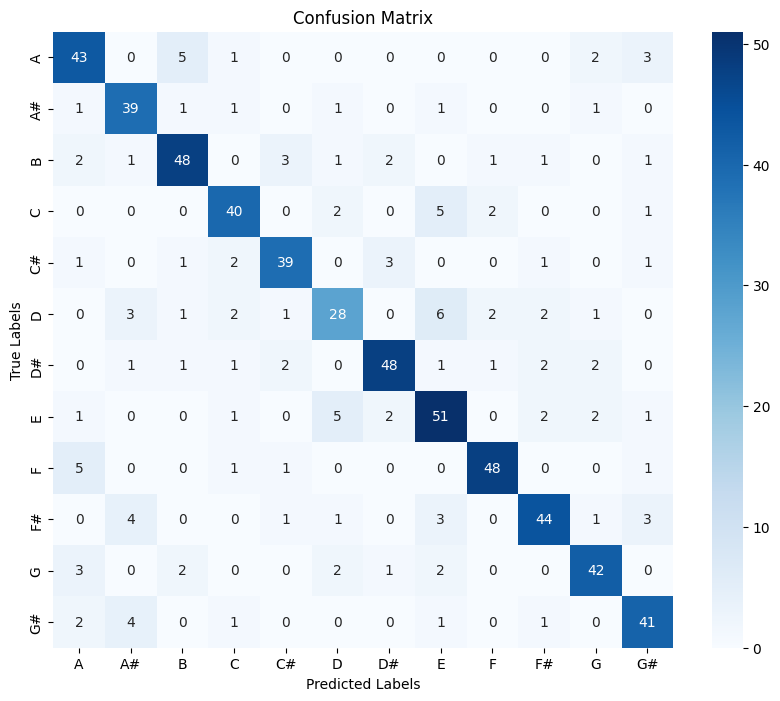

              precision    recall  f1-score   support

           0       0.74      0.80      0.77        54
           1       0.75      0.87      0.80        45
           2       0.81      0.80      0.81        60
           3       0.80      0.80      0.80        50
           4       0.83      0.81      0.82        48
           5       0.70      0.61      0.65        46
           6       0.86      0.81      0.83        59
           7       0.73      0.78      0.76        65
           8       0.89      0.86      0.87        56
           9       0.83      0.77      0.80        57
          10       0.82      0.81      0.82        52
          11       0.79      0.82      0.80        50

    accuracy                           0.80       642
   macro avg       0.80      0.79      0.79       642
weighted avg       0.80      0.80      0.80       642



In [50]:
# Running inference on test set
y_pred = rf_classifier.predict(X_normal)
# Computing classification metrics
classification_metrics = classification_report(y_normal, y_pred)
# Compute the confusion matrix
cm = confusion_matrix(y_normal, y_pred)

# Plotting the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print(classification_metrics)


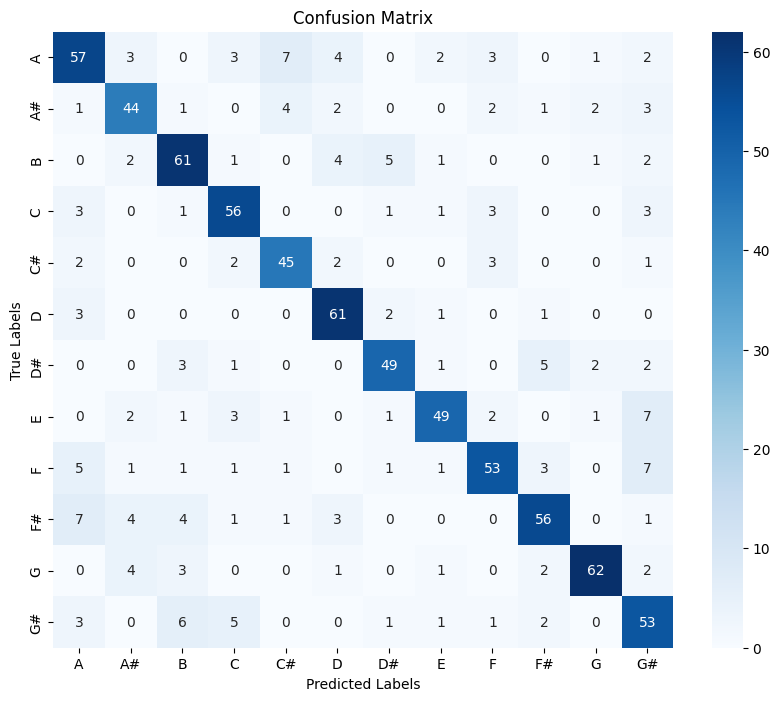

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        82
           1       0.73      0.73      0.73        60
           2       0.75      0.79      0.77        77
           3       0.77      0.82      0.79        68
           4       0.76      0.82      0.79        55
           5       0.79      0.90      0.84        68
           6       0.82      0.78      0.80        63
           7       0.84      0.73      0.78        67
           8       0.79      0.72      0.75        74
           9       0.80      0.73      0.76        77
          10       0.90      0.83      0.86        75
          11       0.64      0.74      0.68        72

    accuracy                           0.77       838
   macro avg       0.78      0.77      0.77       838
weighted avg       0.77      0.77      0.77       838



In [51]:

# Running inference on test set
y_pred = rf_classifier.predict(X_inversions)
# Computing classification metrics
classification_metrics = classification_report(y_inversions, y_pred)
# Compute the confusion matrix
cm = confusion_matrix(y_inversions, y_pred)

# Plotting the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print(classification_metrics)

# SOTA MODEL WITH FULL DATASET

Epoch 1/100


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 436us/step - accuracy: 0.2433 - loss: 2.3624
Epoch 2/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - accuracy: 0.5812 - loss: 1.6599
Epoch 3/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - accuracy: 0.6465 - loss: 1.3377
Epoch 4/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - accuracy: 0.6614 - loss: 1.2413
Epoch 5/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - accuracy: 0.6821 - loss: 1.1966
Epoch 6/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - accuracy: 0.6900 - loss: 1.1606
Epoch 7/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - accuracy: 0.6999 - loss: 1.1233
Epoch 8/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - accuracy: 0.7063 - loss: 1.1235
Epoch 9/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - accuracy: 0.7205 - loss: 1.0687
Epoch 10/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - accuracy: 0.7103 - loss: 1.1159
Epoch 11/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - accuracy: 0.7350 - loss: 1.0221
Epoch 12/100
185/185 ━━━━━━━━━━

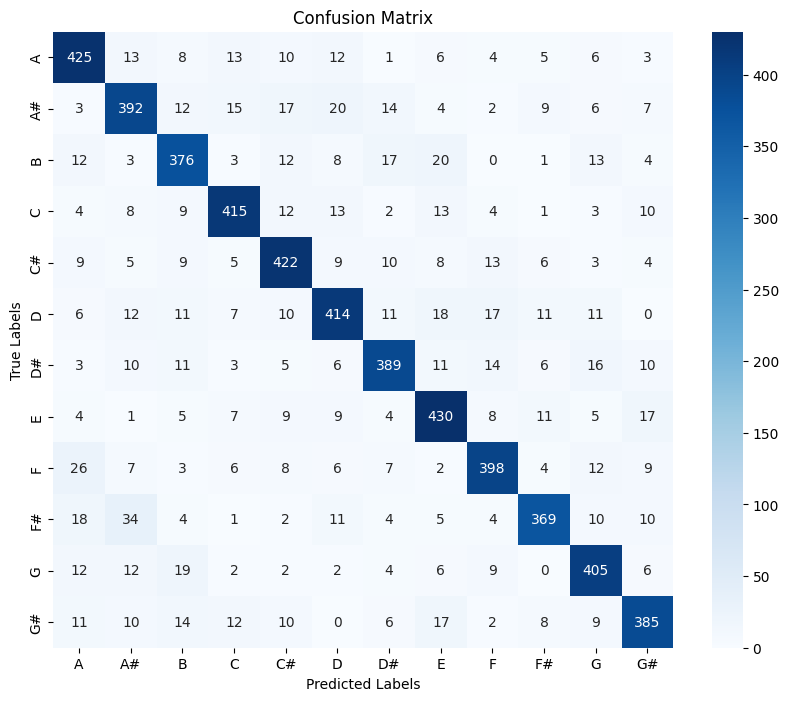

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)                │        832 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_10 (Dense)                │ (None, 64)                │      4,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_11 (Dense)                │ (None, 12)                │        780 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 17,318 (67.65 KB)

 Trainable params: 5,772 (22.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,546 (45.11 KB)

In [52]:
# Define the MLP architecture
def build_model(input_dim, num_classes):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),  # Input layer with ReLU activation
        Dense(64, activation='relu'),                        # Hidden layer with ReLU activation
        Dense(num_classes, activation='softmax')             # Output layer with softmax activation
    ])
    return model

# Parameters
input_dim = 12  # Number of input features
num_classes = 12  # Number of output classes

# Build the model
model = build_model(input_dim, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Dummy dataset for demonstration
# Generate random data for inputs and outputs
np.random.seed(0)
X_train = X_train
Y_train = y_train.to_numpy()

# Convert labels to categorical one-hot encoding
Y_train = np.eye(num_classes)[Y_train.reshape(-1)]

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

Y_pred = model.predict(X_train)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Convert one-hot encoded labels back to class indices
Y_train_classes = np.argmax(Y_train, axis=1)

# Evaluate the model
print("Classification Report:")
print(classification_report(Y_train_classes, Y_pred_classes))

print("Confusion Matrix:")
cm = confusion_matrix(Y_train_classes, Y_pred_classes)
# Plotting the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# Model summary
model.summary()

# SOTA MODEL WITH NORMAL CHORDS

Epoch 1/100


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - accuracy: 0.1069 - loss: 2.4717
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.2112 - loss: 2.3855
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - accuracy: 0.3472 - loss: 2.3024
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - accuracy: 0.3689 - loss: 2.2198
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - accuracy: 0.6050 - loss: 2.0953
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.5697 - loss: 1.9996
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.5871 - loss: 1.8800
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.6763 - loss: 1.7440
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.6673 - loss: 1.6702
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.6451 - loss: 1.5569
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.6914 - loss: 1.4548
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step

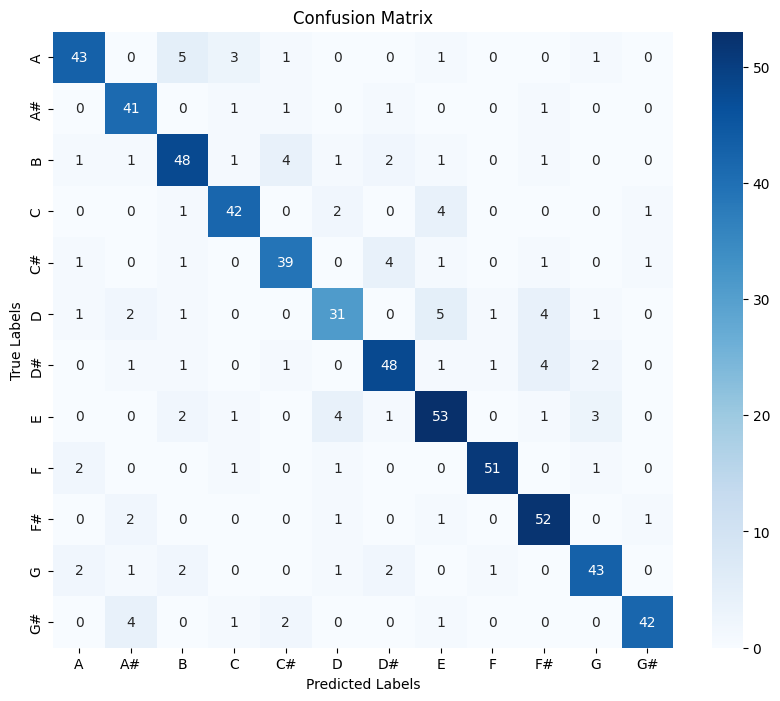

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)                │        832 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_13 (Dense)                │ (None, 64)                │      4,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_14 (Dense)                │ (None, 12)                │        780 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 17,318 (67.65 KB)

 Trainable params: 5,772 (22.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,546 (45.11 KB)

In [53]:
# Define the MLP architecture
def build_model(input_dim, num_classes):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),  # Input layer with ReLU activation
        Dense(64, activation='relu'),                        # Hidden layer with ReLU activation
        Dense(num_classes, activation='softmax')             # Output layer with softmax activation
    ])
    return model

# Parameters
input_dim = 12  # Number of input features
num_classes = 12  # Number of output classes

# Build the model
model = build_model(input_dim, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Dummy dataset for demonstration
# Generate random data for inputs and outputs
np.random.seed(0)
X_train = X_normal
Y_train = y_normal.to_numpy()

# Convert labels to categorical one-hot encoding
Y_train = np.eye(num_classes)[Y_train.reshape(-1)]

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

Y_pred = model.predict(X_train)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Convert one-hot encoded labels back to class indices
Y_train_classes = np.argmax(Y_train, axis=1)

# Evaluate the model
print("Classification Report:")
print(classification_report(Y_train_classes, Y_pred_classes))

print("Confusion Matrix:")
cm = confusion_matrix(Y_train_classes, Y_pred_classes)
# Plotting the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# Model summary
model.summary()

# SOTA MODEL WITH INVERSIONS DATASET

Epoch 1/100


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - accuracy: 0.0724 - loss: 2.4678 
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - accuracy: 0.2322 - loss: 2.4031
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.3510 - loss: 2.3153
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.3891 - loss: 2.2290
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.4620 - loss: 2.1237
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.4458 - loss: 2.0259
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.5240 - loss: 1.9074
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.5452 - loss: 1.7843
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.5201 - loss: 1.7059
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.5494 - loss: 1.6070
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.5862 - loss: 1.5502
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/ste

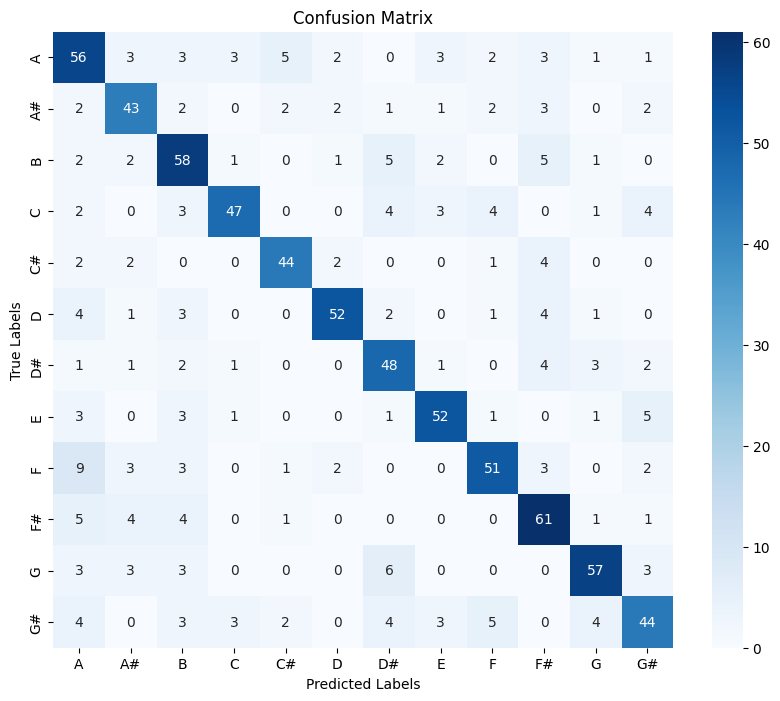

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)                │        832 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_16 (Dense)                │ (None, 64)                │      4,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_17 (Dense)                │ (None, 12)                │        780 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 17,318 (67.65 KB)

 Trainable params: 5,772 (22.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,546 (45.11 KB)

In [54]:
# Define the MLP architecture
def build_model(input_dim, num_classes):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),  # Input layer with ReLU activation
        Dense(64, activation='relu'),                        # Hidden layer with ReLU activation
        Dense(num_classes, activation='softmax')             # Output layer with softmax activation
    ])
    return model

# Parameters
input_dim = 12  # Number of input features
num_classes = 12  # Number of output classes

# Build the model
model = build_model(input_dim, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Dummy dataset for demonstration
# Generate random data for inputs and outputs
np.random.seed(0)
X_train = X_inversions
Y_train = y_inversions.to_numpy()

# Convert labels to categorical one-hot encoding
Y_train = np.eye(num_classes)[Y_train.reshape(-1)]

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

Y_pred = model.predict(X_train)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Convert one-hot encoded labels back to class indices
Y_train_classes = np.argmax(Y_train, axis=1)

# Evaluate the model
print("Classification Report:")
print(classification_report(Y_train_classes, Y_pred_classes))

print("Confusion Matrix:")
cm = confusion_matrix(Y_train_classes, Y_pred_classes)
# Plotting the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# Model summary
model.summary()